# In Berlin, find hot spots: locations where accidents cumulate


In [89]:
import numpy as np
import pandas as pd
import warnings
import os
import geopandas as gpd

ModuleNotFoundError: No module named 'geopandas'

In [90]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib
#matplotlib.rcParams['lines.linewidth'] = 2
#matplotlib.rcParams['savefig.dpi'] = 300
#matplotlib.rcParams['figure.figsize'] = [12,6]

## read Data, reduce to Berlin

In [137]:
acci = pd.read_csv(os.path.join("../data","Unfallorte2019_LinRef.txt"),sep=';', decimal=",")
acci = acci[acci['ULAND']==11]
acci.index = range(len(acci)) # 13,390 rows
# acci.head

In [114]:
acci.columns


Index(['OBJECTID', 'ULAND', 'UREGBEZ', 'UKREIS', 'UGEMEINDE', 'UJAHR',
       'UMONAT', 'USTUNDE', 'UWOCHENTAG', 'UKATEGORIE', 'UART', 'UTYP1',
       'ULICHTVERH', 'IstRad', 'IstPKW', 'IstFuss', 'IstKrad', 'IstGkfz',
       'IstSonstige', 'LINREFX', 'LINREFY', 'XGCSWGS84', 'YGCSWGS84',
       'STRZUSTAND'],
      dtype='object')

In [138]:
l = np.min(acci['XGCSWGS84'])
r = np.max(acci['XGCSWGS84'])
b = np.min(acci['YGCSWGS84'])
t = np.max(acci['YGCSWGS84'])
print(l,r,b,t)

13.09684420700006 13.74096105500007 52.36793148800007 52.66014629400007


In [116]:
print(l,r,b,t)

13.09684420700006 13.74096105500007 52.36793148800007 52.66014629400007


In [117]:
s1 = list(set(acci['XGCSWGS84']))
s1 = np.sort(s1)
le=len(s1)
le, len(s1[1:]), len(s1[:le-1])
resolution_x = min([s1[i+1]-s1[i] for i in range(le-1)])

s1 = list(set(acci['YGCSWGS84']))
s1 = np.sort(s1)
le=len(s1)
le, len(s1[1:]), len(s1[:le-1])
resolution_y = min([s1[i+1]-s1[i] for i in range(le-1)])


The way i did it here, what I calculate as resolution is smaller than the actual minimal distance between actual accidents. Because I first project all x-values on a line and compare them without their y-values. so close x values need not belong to close points (x,y) - the y values may be totally different / indicate a large distance.

In [96]:
resolution_x , resolution_y

(9.999876482424952e-10, 9.99982319171977e-10)

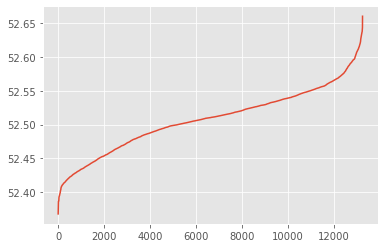

In [97]:
plt.plot(range(le),s1)

In [139]:
res = 0.001
w = int((r-l)/res)+1 # int(0.9) = 0 so it just removes decimal places, a floor operation
h = int((t-b)/res)+1
mymap = np.zeros(w*h).reshape((w,h))
print('shape: ', mymap.shape)

shape:  (645, 293)


In [140]:
# import itertools as it
# idx = iter(it.product(range(w),range(h))) # useless here, not what I want to do
# this could be done directly with zip, no need for itertools?
# for q, a in zip(questions, answers):
#   print('What is your {0}?  It is {1}.'.format(q, a))

#len(acci) # 13,390
# acci.iloc[10]['XGCSWGS84']

# since the +=1 did not work inside the list comprehension we need to do the incrementing with a function:
def incr (ar,i,j): # passing an np.array as ar will be by reference / pointer
    ar[i,j]+=1

[incr(mymap, int((acci.iloc[i]['XGCSWGS84']-l)/res), int((acci.iloc[i]['YGCSWGS84']-b)/res)) for i in acci.index]
print('done')

done


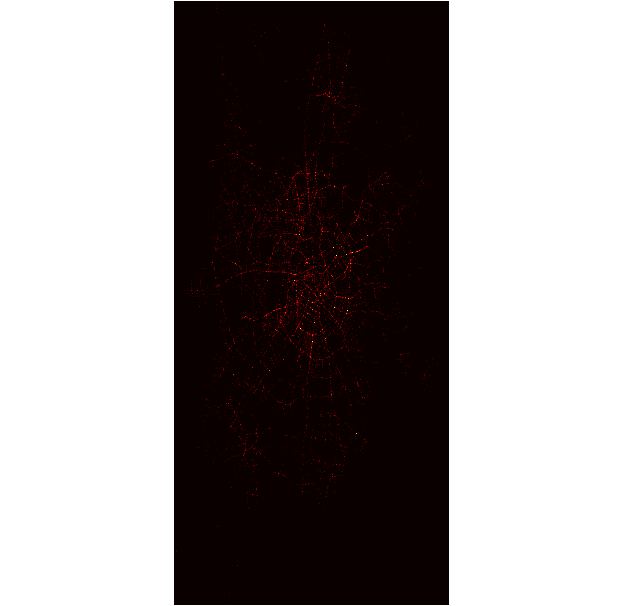

In [141]:
my_dpi= 12
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.imshow(mymap, cmap='hot', interpolation='nearest')
plt.axis('off')
plt.axis('equal') # or 'scaled' but it's not making a difference
#plt.axis('scaled')
plt.savefig('berlin-hotspots.png', format='png', metadata={'location':'berlin','content':'accumulated accidents'})
plt.show()
# remove gridlines, try : plt.axis('off') , plt.grid(b=None)

In [190]:
# check resolution and adjust before saving
np.savetxt('berlin-map-res-01.csv', mymap.astype(int), fmt='%i' , delimiter=',',newline='\n')
#np.savetxt('berlin-map-res-001.csv', mymap.astype(int), fmt='%i' , delimiter=',',newline='\n')
#np.savetxt('berlin-map-res-0001.csv', mymap.astype(int), fmt='%i' , delimiter=',',newline='\n')

In [142]:
# [max(list(mymap[i,:])) for i in range(w-1)] # most cells are empty at resolution 0.0001
max([max(list(mymap[i,:])) for i in range(w-1)]) # 9 is the highest number of accidents within one cell at res = 0.0001

20.0

In [145]:
a1,b1 = np.where(mymap>15)
z = zip(a1,b1)
location=list(z)
#for idx in location:
#    print(mymap[idx])

Get info where these hotspots are. Get a street name or something!

In [154]:
def index2coord (k,m,l=l,b=b):
    '''input: k,m 
    is a cell of a matrix. This cell represents an area in long, lat coordinates. 
    
    output: center of the area represented by the (k,m) matrix cell in long, lat coordinates.'''
    #print(k,m,l,b)
    return ((k+0.5)*res + l,(m+0.5)*res + b)

def coord2index (x,y, l=l, b=b):
    return(int((x-l)/res), int((y-b)/res))

def index2bb (k,m,l=l,b=b):
    '''returns bounding box for the matrix cell, in anti clock wise starting from left (l): l,b,r,t'''
    return (l+k*res, b+m*res, l+(k+1)*res, b+(m+1)*res)

In [125]:
import requests
import json
import shutil

In [161]:
API_KEY = '0a094e7075504645b7e1c83113f851e2'

hot_spots=pd.DataFrame()

print('looping through' , len(location) , 'locations.')

for i in range(len(location)):
    x,y = index2coord(*location[i])
    dict_to_append = {'matrix_index':location[i],'lat':x,'long':y,'accidents':mymap[location[i]]} # start with geo locations
    #get addresses / all available address discriptors for the geo locations
    req = 'https://nominatim.openstreetmap.org/reverse?format=geojson&lat='+str(y)+'&lon='+str(x)+'&addressdetails=1'
    try: 
        dict_address = requests.get(req).json()['features'][0]['properties']['address']
    except:
        print('something went wrong getting the address for',i,x,y)
    else:
        dict_to_append.update(dict_address)
        hot_spots = hot_spots.append(dict_to_append,ignore_index=True)
        
    req='https://maps.geoapify.com/v1/staticmap?style=osm-bright&width=200&height=200&center=lonlat:'+str(x)+','+str(y)+'&zoom=40&apiKey='+str(API_KEY)

    img = requests.get(req, stream=True) # stream=True needed for requesting an image
    if img.status_code == 200:
        # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
        img.raw.decode_content = True
        # print('location'+str(hot_spots.iloc[i]['matrix_index']))
        # Open a local file with wb ( write binary ) permission.
        with open('location_small'+str(hot_spots.iloc[i]['matrix_index']),'wb') as f:
            shutil.copyfileobj(img.raw, f)        
        #print('Image sucessfully downloaded.')
    else:
        pass
        #print('Image Couldn\'t be retreived')

looping through 5 locations.


In [150]:
hot_spots.sort_values(by='borough')

,accidents,borough,country,country_code,lat,long,matrix_index,road,shop,state,suburb,city,district,postcode,house_number,historic
1,20.0,Charlottenburg-Wilmersdorf,Deutschland,de,13.326344,52.538431,"(229, 170)",Seestraße,NaN,Berlin,Charlottenburg-Nord,Berlin,Rixdorf,13627,NaN,NaN
4,16.0,Friedrichshain-Kreuzberg,Deutschland,de,13.446344,52.502431,"(349, 134)",Am Oberbaum,NaN,Berlin,Friedrichshain,Berlin,Rixdorf,10243,NaN,Oberbaumbrücke
2,17.0,Mitte,Deutschland,de,13.368344,52.541431,"(271, 173)",Müllerstraße,NaN,Berlin,Wedding,Berlin,Rixdorf,13353,6,NaN
3,17.0,Pankow,Deutschland,de,13.427344,52.552431,"(330, 184)",Wisbyer Straße,NaN,Berlin,Prenzlauer Berg,Berlin,Rixdorf,13189,38,NaN
0,17.0,Spandau,Deutschland,de,13.199344,52.534431,"(102, 166)",Klosterstraße,Blütenreich,Berlin,Spandau,NaN,NaN,NaN,NaN,NaN


Select usefull columns

In [151]:
hot_spots = hot_spots[['lat','long','road','borough','postcode','accidents','matrix_index']]
hot_spots.sort_values(by='borough')

,lat,long,road,borough,postcode,accidents,matrix_index
1,13.326344,52.538431,Seestraße,Charlottenburg-Wilmersdorf,13627,20.0,"(229, 170)"
4,13.446344,52.502431,Am Oberbaum,Friedrichshain-Kreuzberg,10243,16.0,"(349, 134)"
2,13.368344,52.541431,Müllerstraße,Mitte,13353,17.0,"(271, 173)"
3,13.427344,52.552431,Wisbyer Straße,Pankow,13189,17.0,"(330, 184)"
0,13.199344,52.534431,Klosterstraße,Spandau,NaN,17.0,"(102, 166)"


Done.

Or we can count only subsets of accidents and produce a different ranking: Hot spots for accidents involving pedestrians or bikes.

## Size of squares in mymap

In [136]:
mymap[0,0], mymap[0,1] # number of accidents

(0.0, 0.0)

In [156]:
index2bb(*location[0])

(13.198844207000061, 52.533931488000064, 13.19984420700006, 52.53493148800007)

## Map for accidents with pedestrians

In [71]:
acci = acci[acci['ULAND']==11]
acci = acci[acci['IstRad']==1]
acci.index = range(len(acci)) # 5005 rows
print('working with',len(acci),'accidents involving cyclists.')
l = np.min(acci['XGCSWGS84'])
r = np.max(acci['XGCSWGS84'])
b = np.min(acci['YGCSWGS84'])
t = np.max(acci['YGCSWGS84'])
res = 0.01
w = int((r-l)/res)+1 # int(0.9) = 0 so it just removes decimal places, a floor operation
h = int((t-b)/res)+1
mymap = np.zeros(w*h).reshape((w,h))
[incr(mymap, int((acci.iloc[i]['XGCSWGS84']-l)/res), int((acci.iloc[i]['YGCSWGS84']-b)/res)) for i in acci.index]
print('map is built. It is a matrix of size', mymap.shape)
print('map has long, lat bounding box (l,b,r,t)', l,b,r,t) # left,bottom,right,top
# https://wiki.openstreetmap.org/wiki/DE:Bounding_Box
print('highest number of accidents in cell is:',max([max(list(mymap[i,:])) for i in range(w-1)]))
thresh=40
a1,b1 = np.where(mymap>thresh)
z = zip(a1,b1)
location=list(z)
print('number of cells with more than',thresh,'accidents:',len(location))

working with 5005 accidents involving cyclists.
map is built. It is a matrix of size (63, 30)
map has long, lat bounding box (l,b,r,t) 13.109238032000064 52.36793148800007 13.730559311000034 52.66014629400007
highest number of accidents in cell is: 58.0
number of cells with more than 40 accidents: 15


In [69]:
hot_spots.sort_values(by='borough')

,accidents,borough,city,country,country_code,district,lat,long,matrix_index,postcode,...,state,suburb,house_number,leisure,place,tourism,building,neighbourhood,amenity,historic
2,52.0,Friedrichshain-Kreuzberg,Berlin,Deutschland,de,Rixdorf,13.381844,52.492931,"(28, 12)",10965,...,Berlin,Kreuzberg,74,Spielothek 21,NaN,NaN,NaN,NaN,NaN,NaN
3,41.0,Friedrichshain-Kreuzberg,Berlin,Deutschland,de,Rixdorf,13.381844,52.502931,"(28, 13)",10963,...,Berlin,Kreuzberg,6,NaN,Lilli-Hennoch Sportplatz,NaN,NaN,NaN,NaN,NaN
8,58.0,Friedrichshain-Kreuzberg,Berlin,Deutschland,de,Rixdorf,13.401844,52.502931,"(30, 13)",10969,...,Berlin,Kreuzberg,NaN,NaN,NaN,NaN,NaN,Luisenstadt,Freie Waldorfschule Kreuzberg e.V.,NaN
11,46.0,Friedrichshain-Kreuzberg,Berlin,Deutschland,de,Rixdorf,13.411844,52.502931,"(31, 13)",10969,...,Berlin,Kreuzberg,35-38,Prinzessinnengarten,NaN,NaN,NaN,Luisenstadt,NaN,NaN
12,57.0,Friedrichshain-Kreuzberg,Berlin,Deutschland,de,Rixdorf,13.431844,52.502931,"(33, 13)",10997,...,Berlin,Kreuzberg,37,NaN,NaN,NaN,NaN,Luisenstadt,NaN,NaN
13,56.0,Friedrichshain-Kreuzberg,Berlin,Deutschland,de,Rixdorf,13.441844,52.512931,"(34, 14)",10243,...,Berlin,Friedrichshain,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,52.0,Friedrichshain-Kreuzberg,Berlin,Deutschland,de,Rixdorf,13.451844,52.512931,"(35, 14)",10243,...,Berlin,Friedrichshain,14A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,43.0,Mitte,Berlin,Deutschland,de,Rixdorf,13.361844,52.512931,"(26, 14)",10785,...,Berlin,Tiergarten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49.0,Mitte,Berlin,Deutschland,de,Rixdorf,13.371844,52.512931,"(27, 14)",10785,...,Berlin,Tiergarten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,42.0,Mitte,Berlin,Deutschland,de,Rixdorf,13.381844,52.512931,"(28, 14)",10117,...,Berlin,Mitte,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
hot_spots.columns

Index(['accidents', 'borough', 'city', 'country', 'country_code', 'district',
       'house_number', 'lat', 'long', 'matrix_index', 'postcode', 'road',
       'shop', 'state', 'suburb', 'neighbourhood', 'highway', 'office',
       'leisure', 'tourism', 'amenity', 'building'],
      dtype='object')

In [70]:
hot_spots = hot_spots[['lat','long','road','borough','postcode','accidents','matrix_index']]
hot_spots.sort_values(by='borough')

,lat,long,road,borough,postcode,accidents,matrix_index
2,13.381844,52.492931,Yorckstraße,Friedrichshain-Kreuzberg,10965,52.0,"(28, 12)"
3,13.381844,52.502931,Askanischer Platz,Friedrichshain-Kreuzberg,10963,41.0,"(28, 13)"
8,13.401844,52.502931,Ritterstraße,Friedrichshain-Kreuzberg,10969,58.0,"(30, 13)"
11,13.411844,52.502931,Prinzenstraße,Friedrichshain-Kreuzberg,10969,46.0,"(31, 13)"
12,13.431844,52.502931,Pücklerstraße,Friedrichshain-Kreuzberg,10997,57.0,"(33, 13)"
13,13.441844,52.512931,Rüdersdorfer Straße,Friedrichshain-Kreuzberg,10243,56.0,"(34, 14)"
14,13.451844,52.512931,Warschauer Straße,Friedrichshain-Kreuzberg,10243,52.0,"(35, 14)"
0,13.361844,52.512931,Bellevueallee,Mitte,10785,43.0,"(26, 14)"
1,13.371844,52.512931,Ahornsteig,Mitte,10785,49.0,"(27, 14)"
4,13.381844,52.512931,Wilhelmstraße,Mitte,10117,42.0,"(28, 14)"


## code to learn from

In [477]:
df = pd.DataFrame(columns=['lat','long'])
for i in range(5):
    x,y= x,y = index2coord(*location[i])
    df = df.append({'lat': x, 'long':y}, ignore_index=True)
df


,lat,long
0,13.199794,52.534781
1,13.315094,52.490881
2,13.360294,52.537281
3,13.365494,52.557981
4,13.368394,52.541081


In [320]:
# turning a dictionray into a data frame
d = {1: "a", 2: "b", 3:"c"}
# one option
dd1 = pd.DataFrame(d.items(), columns=['col1', 'col2'])
print('*** option 1 ***')
print(dd1)
# another option - different result !
dd2 = pd.DataFrame([d])
print('*** option 2 ***')
print(dd2)

*** option 1 ***
   col1 col2
0     1    a
1     2    b
2     3    c
*** option 2 ***
   1  2  3
0  a  b  c


In [407]:
d={'lat':x,'long':y}
pd.DataFrame(data=d,index=[2])

,lat,long
2,13.558294,52.562881


In [408]:
df = pd.DataFrame(columns=['A'])
for i in range(5):
    df = df.append({'A': i}, ignore_index=True)
df

,A
0,0
1,1
2,2
3,3
4,4


# Getting positions for Bundesländer
from openstreetmap API
Then plotting number of accidents in a north - south fashion
or plotting as in the position of the Bundesländer, with a circle representing the numer of accidents

The following includes a shop in Berlin, a bakery, we need the properties:{category: boundary , type:administrative} and then access the feature , geometry, coordinates (9.19 , 50.61 , check if it is long lat or lat long)

In [7]:
import requests
import json

In [282]:
# response = requests.get('https://nominatim.openstreetmap.org/search?q=Frankfurt+am+Main%2CHesse&format=geojson')
response = requests.get('https://nominatim.openstreetmap.org/search?q=Hesse%2CGermany&format=geojson')
#Response as JSON print(response.json())
d0 = response.json()
d1 = json.dumps(d0, sort_keys=True, indent=2)
#d0.keys()
d0['features'][0]

{'type': 'Feature',
 'properties': {'place_id': 234606145,
  'osm_type': 'relation',
  'osm_id': 62650,
  'display_name': 'Hessen, Deutschland',
  'place_rank': 8,
  'category': 'boundary',
  'type': 'administrative',
  'importance': 0.7673228712714227,
  'icon': 'https://nominatim.openstreetmap.org/ui/mapicons//poi_boundary_administrative.p.20.png'},
 'bbox': [7.7724063, 49.3952611, 10.2364858, 51.657817],
 'geometry': {'type': 'Point', 'coordinates': [9.1909725, 50.6118537]}}

In [33]:
d = response.json() # d as dictionary

In [48]:
d['features'][0]['geometry']['coordinates']

[8.6820917, 50.1106444]

In [53]:
d['features'][0]['properties']['category']

'boundary'

In [54]:
d['features'][0]['properties']['type']

'administrative'